Using device: cuda
>>> Running Experiment 1: Rosenbrock Visualization...


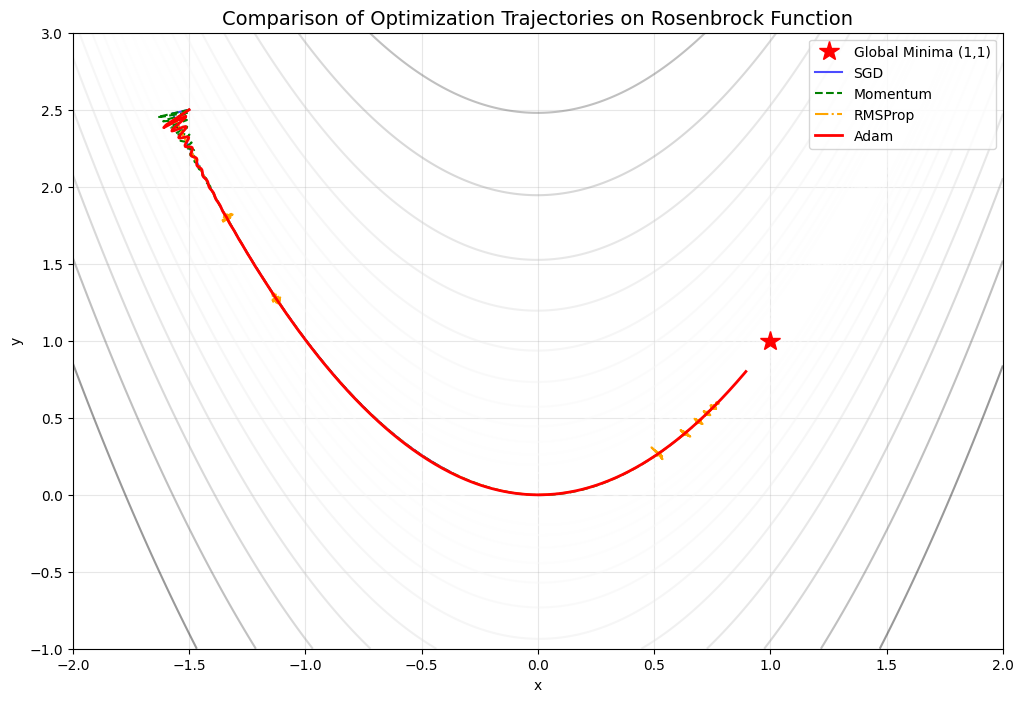

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.08MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]



>>> Running Experiment 2: Training on FashionMNIST...
Training with SGD...
--> Done SGD. Time: 118.42s | Final Acc: 82.76%
Training with Momentum...
--> Done Momentum. Time: 117.99s | Final Acc: 88.30%
Training with Nesterov...
--> Done Nesterov. Time: 118.62s | Final Acc: 88.49%
Training with Adagrad...
--> Done Adagrad. Time: 118.52s | Final Acc: 87.63%
Training with RMSprop...
--> Done RMSprop. Time: 118.70s | Final Acc: 86.50%
Training with Adadelta...
--> Done Adadelta. Time: 117.53s | Final Acc: 87.19%
Training with Adam...
--> Done Adam. Time: 117.41s | Final Acc: 89.17%


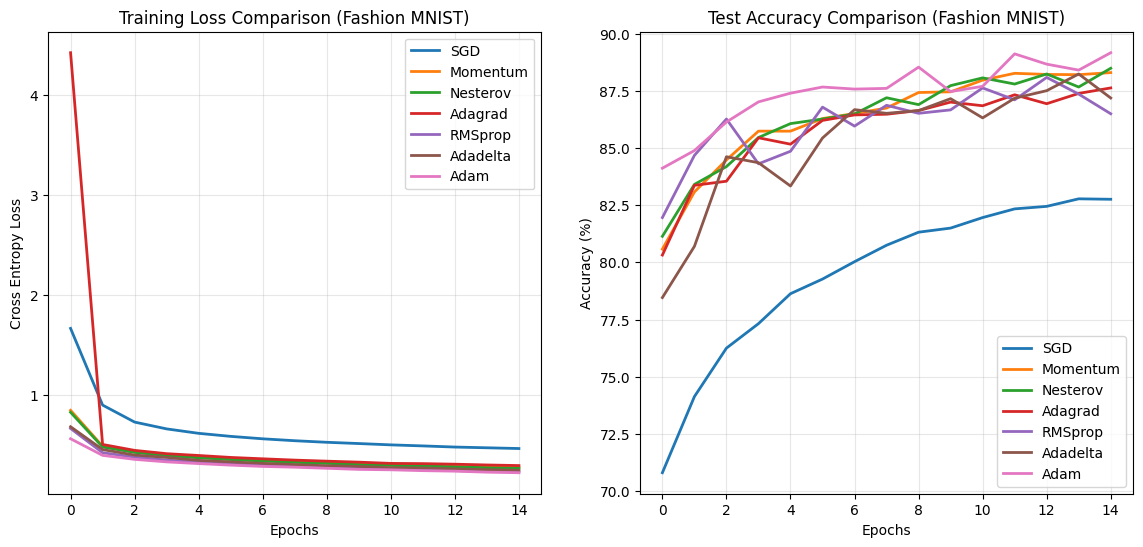


All experiments completed! Images saved.


In [1]:
# ======================================================================================
# CHAPTER 4 EXPERIMENTS: FIRST-ORDER OPTIMIZATION METHODS
# AUTHOR: [Tên của bạn]
# SETUP: Chạy trên Kaggle/Colab với GPU (nếu có, không bắt buộc)
# ======================================================================================

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# Cấu hình device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================================================
# PHẦN 1: TRỰC QUAN HÓA TRÊN HÀM ROSENBROCK (TOY PROBLEM)
# Mục đích: So sánh hành vi di chuyển của các thuật toán trong thung lũng hẹp
# ======================================================================================

def rosenbrock(x, y):
    return (1 - x)**2 + 100 * (y - x**2)**2

def grad_rosenbrock(x, y):
    dx = -2 * (1 - x) - 400 * x * (y - x**2)
    dy = 200 * (y - x**2)
    return np.array([dx, dy])

# Các class Optimizer thủ công (numpy version) để vẽ đường đi
class Optimizer:
    def __init__(self, lr=0.001): self.lr = lr
    def step(self, params, grads): pass

class SGD(Optimizer):
    def step(self, params, grads):
        return params - self.lr * grads

class Momentum(Optimizer):
    def __init__(self, lr=0.001, beta=0.9):
        super().__init__(lr)
        self.beta = beta
        self.v = 0
    def step(self, params, grads):
        self.v = self.beta * self.v + self.lr * grads # Standard Momentum formula
        return params - self.v

class Adam(Optimizer):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(lr)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.m, self.v, self.t = 0, 0, 0
    def step(self, params, grads):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads**2)
        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)
        return params - self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

class RMSProp(Optimizer):
    def __init__(self, lr=0.01, decay=0.99, eps=1e-8):
        super().__init__(lr)
        self.decay, self.eps = decay, eps
        self.cache = 0
    def step(self, params, grads):
        self.cache = self.decay * self.cache + (1 - self.decay) * (grads**2)
        return params - self.lr * grads / (np.sqrt(self.cache) + self.eps)

def run_optimization(opt_class, start_pos, iterations=200, **kwargs):
    path = [start_pos]
    params = np.array(start_pos)
    opt = opt_class(**kwargs)
    
    for _ in range(iterations):
        grads = grad_rosenbrock(params[0], params[1])
        params = opt.step(params, grads)
        path.append(params)
    return np.array(path)

# --- VẼ BIỂU ĐỒ SO SÁNH ---
def plot_rosenbrock_paths():
    x = np.linspace(-2, 2, 250)
    y = np.linspace(-1, 3, 250)
    X, Y = np.meshgrid(x, y)
    Z = rosenbrock(X, Y)

    start_pos = [-1.5, 2.5] # Điểm bắt đầu khó
    
    # Chạy các thuật toán
    path_sgd = run_optimization(SGD, start_pos, lr=0.0005, iterations=3000)
    path_mom = run_optimization(Momentum, start_pos, lr=0.0005, beta=0.9, iterations=500)
    path_rms = run_optimization(RMSProp, start_pos, lr=0.01, iterations=1000)
    path_adam = run_optimization(Adam, start_pos, lr=0.1, iterations=500)

    plt.figure(figsize=(12, 8))
    plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='gray_r', alpha=0.4)
    plt.plot(1, 1, 'r*', markersize=15, label='Global Minima (1,1)') # Đích đến

    # Vẽ đường đi
    plt.plot(path_sgd[:,0], path_sgd[:,1], label='SGD', color='blue', alpha=0.7)
    plt.plot(path_mom[:,0], path_mom[:,1], label='Momentum', color='green', linestyle='--')
    plt.plot(path_rms[:,0], path_rms[:,1], label='RMSProp', color='orange', linestyle='-.')
    plt.plot(path_adam[:,0], path_adam[:,1], label='Adam', color='red', linewidth=2)

    plt.title("Comparison of Optimization Trajectories on Rosenbrock Function", fontsize=14)
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('rosenbrock_comparison.png', dpi=300) # LƯU ẢNH 1
    plt.show()

print(">>> Running Experiment 1: Rosenbrock Visualization...")
plot_rosenbrock_paths()


# ======================================================================================
# PHẦN 2: HUẤN LUYỆN NEURAL NETWORK TRÊN FASHION MNIST
# Mục đích: So sánh Loss và Accuracy thực tế
# ======================================================================================

# 1. Load Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Dùng batch size lớn để gradient ổn định hơn, dễ so sánh
batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# 2. Define Model (Simple MLP)
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# 3. Training Function
def train_model(optimizer_name, learning_rate=0.001, epochs=10):
    model = SimpleMLP().to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Chọn Optimizer
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Momentum':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'Nesterov':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == 'Adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=learning_rate) # Adagrad often needs higher LR
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = optim.Adadelta(model.parameters()) # No LR needed usually
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    loss_history = []
    acc_history = []
    
    print(f"Training with {optimizer_name}...")
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Evaluate on Test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        loss_history.append(epoch_loss)
        acc_history.append(epoch_acc)
        
        # print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")
        
    training_time = time.time() - start_time
    print(f"--> Done {optimizer_name}. Time: {training_time:.2f}s | Final Acc: {acc_history[-1]:.2f}%")
    return loss_history, acc_history

# 4. Run Experiments
optimizers_to_test = {
    'SGD': 0.01,
    'Momentum': 0.01,
    'Nesterov': 0.01,
    'Adagrad': 0.05, # Adagrad need higher LR
    'RMSprop': 0.001,
    'Adadelta': 1.0, # Default for Adadelta
    'Adam': 0.001
}

results = {}

print("\n>>> Running Experiment 2: Training on FashionMNIST...")
for opt_name, lr in optimizers_to_test.items():
    losses, accs = train_model(opt_name, learning_rate=lr, epochs=15)
    results[opt_name] = {'loss': losses, 'acc': accs}

# 5. Plotting Results
plt.figure(figsize=(14, 6))

# Subplot 1: Training Loss
plt.subplot(1, 2, 1)
for opt_name in results:
    plt.plot(results[opt_name]['loss'], label=opt_name, linewidth=2)
plt.title('Training Loss Comparison (Fashion MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Test Accuracy
plt.subplot(1, 2, 2)
for opt_name in results:
    plt.plot(results[opt_name]['acc'], label=opt_name, linewidth=2)
plt.title('Test Accuracy Comparison (Fashion MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('training_comparison.png', dpi=300) # LƯU ẢNH 2
plt.show()

print("\nAll experiments completed! Images saved.")